# Importação das dependências

In [1]:
import os
import json
import platform
import shutil
import numpy as np
import pandas as pd
import torch
import glob
import joblib
from datetime import datetime
import pytorch_lightning as pl
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, LearningRateMonitor

torch.__version__

'2.9.1'

In [2]:
torch.manual_seed(42)

# Configuração Inicial

In [3]:
class Config:
    def __init__(self, ticker: str):
        # Carregar do JSON
        config_path = f'configs/{ticker}.json'
        with open(config_path, 'r') as f:
            data = json.load(f)
        
        # Atribuir todos os valores do JSON
        for key, value in data.items():
            setattr(self, key, value)
        
        # Valores calculados/dinâmicos/Fixos (não vão no JSON)
        self.TICKER = ticker
        self.INPUT_SIZE = len(self.FEATURE_COLS)
        self.CHECKPOINT_DIR = "checkpoints"
        self.MIN_LOSS = np.inf
        self.NUM_WORKERS = 0 if platform.system() == "Darwin" else 2
        self.ACCELERATOR = torch.device(
            "cuda" if torch.cuda.is_available()
            else "mps" if torch.backends.mps.is_available()
            else "cpu"
        )

In [4]:
config = Config("ITUB4")

print(f"✅ Config carregado: {config.TICKER}")
print(f"   Features: {len(config.FEATURE_COLS)}")
print(f"   Sequence length: {config.SEQUENCE_LENGTH}")
print(f"   Batch size: {config.BATCH_SIZE}")
print(f"   Accelerator: {config.ACCELERATOR}")

✅ Config carregado: ITUB4
   Features: 23
   Sequence length: 90
   Batch size: 32
   Accelerator: mps


In [5]:
def drop_columns(df):
    return df.drop(columns=config.DROP_COLUMNS, errors='ignore')

In [6]:
pd.set_option('display.max_columns', None)
full_df = pd.read_parquet(f'data/train/{config.TICKER}.parquet')
full_df.shape

(1928, 30)

In [7]:
full_df = full_df.tail(config.DF_SIZE).reset_index(drop=True)

# Tratamento dos dados.

In [8]:
class SequenceDataset(Dataset):
    """
    Dataset com FEATURES E TARGET normalizados
    """

    def __init__(self, df, sequence_length, feature_cols, target_col,
                 feature_scaler=None, target_scaler=None, fit_scalers=True):
        self.sequence_length = sequence_length
        self.feature_cols = feature_cols
        self.target_col = target_col

        # Normalizar FEATURES
        if fit_scalers:
            self.feature_scaler = MinMaxScaler()
            scaled_features = self.feature_scaler.fit_transform(df[feature_cols])
        else:
            self.feature_scaler = feature_scaler
            scaled_features = self.feature_scaler.transform(df[feature_cols])

        # Normalizar TARGET
        if fit_scalers:
            self.target_scaler = MinMaxScaler()
            scaled_targets = self.target_scaler.fit_transform(df[[target_col]])
        else:
            self.target_scaler = target_scaler
            scaled_targets = self.target_scaler.transform(df[[target_col]])

        self.features = scaled_features
        self.targets = scaled_targets.squeeze()

        # Criar sequências
        self.X, self.y = self._create_sequences()

    def _create_sequences(self):
        X, y = [], []
        for i in range(self.sequence_length, len(self.features)):
            X.append(self.features[i - self.sequence_length:i])
            y.append(self.targets[i])
        return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]), torch.tensor(self.y[idx])

    def get_scalers(self):
        return self.feature_scaler, self.target_scaler


print("Dataset criado com sucesso!")

Dataset criado com sucesso!


In [9]:
class StocksDataModule(pl.LightningDataModule):
    @staticmethod
    def drop_columns(df, columns):
        return df.drop(columns=columns, errors='ignore')

    def __init__(self, df, config):
        super().__init__()
        self.config = config
        self.df = self.drop_columns(df, self.config.DROP_COLUMNS)

        # Scalers a serem ajustados no setup
        self.feature_scaler = None
        self.target_scaler = None

        # Datasets
        self.train_dataset = None
        self.val_dataset = None
        self.test_dataset = None
    
    def setup(self, stage=None):
        config = self.config
        df = self.df

        print(f"\n{'='*60}")
        print(f"PREPARANDO DADOS")
        print(f"{'='*60}")
        
        # Calcular índices de split (temporal, não aleatório!)
        n_samples = len(df) - config.SEQUENCE_LENGTH
        train_end = int(n_samples * config.TRAIN_RATIO)
        val_end = int(n_samples * (config.TRAIN_RATIO + config.VAL_RATIO))

        print(f"\n📊 Dataset original: {len(df)} registros")
        print(f"   Após criar sequências: {n_samples} samples")
        print(f"   Train: {train_end} samples ({config.TRAIN_RATIO*100:.0f}%)")
        print(f"   Val: {val_end - train_end} samples ({config.VAL_RATIO*100:.0f}%)")

        print(f"\n📊 Splits: Train={train_end}, Val={val_end-train_end}, Test={n_samples-val_end}")

        # Criar dataset de TREINO
        self.train_dataset = SequenceDataset(
            df=df,
            sequence_length=config.SEQUENCE_LENGTH,
            feature_cols=config.FEATURE_COLS,
            target_col=config.TARGET_COL,
            feature_scaler=None,
            target_scaler=None,
            fit_scalers=True
        )

        # Salvar os scalers
        self.feature_scaler, self.target_scaler = self.train_dataset.get_scalers()

        # Criar datasets de VAL e TEST (usam os mesmos scalers)
        self.val_dataset = SequenceDataset(
            df=df,
            sequence_length=config.SEQUENCE_LENGTH,
            feature_cols=config.FEATURE_COLS,
            target_col=config.TARGET_COL,
            feature_scaler=self.feature_scaler,
            target_scaler=self.target_scaler,
            fit_scalers=False
        )

        self.test_dataset = SequenceDataset(
            df=df,
            sequence_length=config.SEQUENCE_LENGTH,
            feature_cols=config.FEATURE_COLS,
            target_col=config.TARGET_COL,
            feature_scaler=self.feature_scaler,
            target_scaler=self.target_scaler,
            fit_scalers=False
        )

        # Split temporal
        self.train_dataset.X = self.train_dataset.X[:train_end]
        self.train_dataset.y = self.train_dataset.y[:train_end]
        
        self.val_dataset.X = self.val_dataset.X[train_end:val_end]
        self.val_dataset.y = self.val_dataset.y[train_end:val_end]
        
        self.test_dataset.X = self.test_dataset.X[val_end:]
        self.test_dataset.y = self.test_dataset.y[val_end:]
        
        print(f"✅ Datasets prontos:")
        print(f"   Train: {len(self.train_dataset)}")
        print(f"   Val: {len(self.val_dataset)}")
        print(f"   Test: {len(self.test_dataset)}")
        

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.config.BATCH_SIZE,
            shuffle=True,
            num_workers=self.config.NUM_WORKERS
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.config.BATCH_SIZE,
            shuffle=False,
            num_workers=self.config.NUM_WORKERS
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.config.BATCH_SIZE,
            shuffle=False,
            num_workers=self.config.NUM_WORKERS
        )

# Construção da LSTM

In [10]:
class StocksLSTM(pl.LightningModule):
  def __init__(self, config):
    super().__init__()

    self.config = config

    self.lstm1 = nn.LSTM(input_size=len(config.FEATURE_COLS), hidden_size=config.INIT_HIDDEN_SIZE)
    self.lstm2 = nn.LSTM(config.INIT_HIDDEN_SIZE, config.SECOND_HIDDEN_SIZE)
    self.lstm3 = nn.LSTM(config.SECOND_HIDDEN_SIZE, config.SECOND_HIDDEN_SIZE, dropout=config.DROPOUT_VALUE, num_layers=config.NUM_LAYERS)
    self.dropout = nn.Dropout(p = config.DROPOUT_VALUE)
    self.linear = nn.Linear(in_features=config.SECOND_HIDDEN_SIZE, out_features=1)
    # self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    #(batch_size, timesteps) -> (timesteps, batch_size, dimensions)
    # x = x.permute(1, 0).unsqueeze(2)

    x = x.permute(1, 0, 2) # -> Mesma coisa da linha debaixo, de forma "contraída"
    x, _ = self.lstm1(x)
    x = self.dropout(x)
    x, _ = self.lstm2(x)
    x = self.dropout(x)
    x, _ = self.lstm3(x)

    x = x[-1]
    x = self.dropout(x)
    x = self.linear(x)
    # x = self.sigmoid(x)

    return x

  
  def training_step(self, batch, batch_idx):
    inputs, targets = batch

    outputs = self(inputs).flatten() # -> self(inputs) -> chama o forward
    loss = nn.functional.mse_loss(outputs, targets)

    self.log("train_loss", loss, prog_bar=True)
    return loss
  
  def validation_step(self, batch, batch_idx):
    inputs, targets = batch

    outputs = self(inputs).flatten()
    loss = nn.functional.mse_loss(outputs, targets)

    self.log("val_loss", loss, prog_bar=True)
    return loss
  
  def test_step(self, batch, batch_idx):
    inputs, targets = batch

    outputs = self(inputs).flatten()
    loss = nn.functional.mse_loss(outputs, targets)

    self.log("test_loss", loss, prog_bar=True)
    return loss
  
  def predict_step(self, batch, batch_idx):
    inputs, _ = batch
    return self(inputs).flatten()

  def configure_optimizers(self):
    optimizer = optim.Adam(
      self.parameters(),
      lr=self.config.LEARNING_RATE,
      weight_decay=self.config.WEIGHT_DECAY
    )

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
      optimizer,
      mode='min',
      factor = self.config.RLR_FACTOR,
      patience=self.config.RLR_PATIENCE
    )

    return {
      'optimizer': optimizer,
      'lr_scheduler': {
        'scheduler': scheduler,
        'monitor': 'val_loss' # Métrica que o scheduler observa
      }
    }

# Treinamento

In [11]:
# Early Stopping - para se val_los não melhorar
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=config.ES_PATIENCE,
    min_delta=config.ES_MIN_DELTA,
    mode='min',
    verbose=True
)

# Model Checkpoint - Salva o melhor modelo.
checkpoint = ModelCheckpoint(
    dirpath=config.CHECKPOINT_DIR,
    filename='best-{epoch:02d}-{val_loss:.4f}',
    monitor='val_loss',
    mode='min',
    save_top_k=1, # -> Salva o melhor modelo
    verbose=True
)

# LR Monitor - mostra o LR atual no progresso
lr_monitor = LearningRateMonitor(logging_interval='epoch')

print("✅ Callbacks configurados!")

✅ Callbacks configurados!


In [12]:
# Criar o Trainer
trainer = pl.Trainer(
    max_epochs=config.EPOCHS,
    accelerator='auto', # Detecta GPU/MPS/CPU automaticamente
    callbacks=[
        early_stopping,
        checkpoint,
        lr_monitor
    ],
    log_every_n_steps=config.LOG_EVERY_N_STEPS,
    gradient_clip_val=config.GRADIENT_CLIP_VAL,
)

print("✅ Trainer configurado!")

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


✅ Trainer configurado!


In [13]:
model = StocksLSTM(config)
datamodule = StocksDataModule(df=full_df, config=config)

if os.path.exists(config.CHECKPOINT_DIR):
    shutil.rmtree(config.CHECKPOINT_DIR)
os.makedirs(config.CHECKPOINT_DIR, exist_ok=True)
print("✅ Pasta de checkpoints limpa!")

# Treinar o modelo
trainer.fit(model, datamodule=datamodule)

✅ Pasta de checkpoints limpa!

PREPARANDO DADOS

📊 Dataset original: 1928 registros
   Após criar sequências: 1838 samples
   Train: 1470 samples (80%)
   Val: 184 samples (10%)

📊 Splits: Train=1470, Val=184, Test=184



  | Name    | Type    | Params | Mode  | FLOPs
----------------------------------------------------
0 | lstm1   | LSTM    | 180 K  | train | 0    
1 | lstm2   | LSTM    | 120 K  | train | 0    
2 | lstm3   | LSTM    | 161 K  | train | 0    
3 | dropout | Dropout | 0      | train | 0    
4 | linear  | Linear  | 101    | train | 0    
----------------------------------------------------
462 K     Trainable params
0         Non-trainable params
462 K     Total params
1.850     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode
0         Total Flops


✅ Datasets prontos:
   Train: 1470
   Val: 184
   Test: 184
Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 15.81it/s]

/Users/rebert.m.teixeira/src/AI/notebooks/.venv/lib/python3.14/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


/Users/rebert.m.teixeira/src/AI/notebooks/.venv/lib/python3.14/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 46/46 [00:02<00:00, 22.25it/s, v_num=40, train_loss=0.110, val_loss=0.0711]

Metric val_loss improved. New best score: 0.071
Epoch 0, global step 46: 'val_loss' reached 0.07110 (best 0.07110), saving model to '/Users/rebert.m.teixeira/src/AI/notebooks/checkpoints/best-epoch=00-val_loss=0.0711.ckpt' as top 1


Epoch 1: 100%|██████████| 46/46 [00:01<00:00, 32.71it/s, v_num=40, train_loss=0.0792, val_loss=0.0158] 

Metric val_loss improved by 0.055 >= min_delta = 0.0001. New best score: 0.016
Epoch 1, global step 92: 'val_loss' reached 0.01581 (best 0.01581), saving model to '/Users/rebert.m.teixeira/src/AI/notebooks/checkpoints/best-epoch=01-val_loss=0.0158.ckpt' as top 1


Epoch 2: 100%|██████████| 46/46 [00:01<00:00, 23.66it/s, v_num=40, train_loss=0.0359, val_loss=0.0195] 

Epoch 2, global step 138: 'val_loss' was not in top 1


Epoch 3: 100%|██████████| 46/46 [00:01<00:00, 32.95it/s, v_num=40, train_loss=0.0358, val_loss=0.006]  

Metric val_loss improved by 0.010 >= min_delta = 0.0001. New best score: 0.006
Epoch 3, global step 184: 'val_loss' reached 0.00600 (best 0.00600), saving model to '/Users/rebert.m.teixeira/src/AI/notebooks/checkpoints/best-epoch=03-val_loss=0.0060.ckpt' as top 1


Epoch 4: 100%|██████████| 46/46 [00:01<00:00, 32.38it/s, v_num=40, train_loss=0.0194, val_loss=0.00582]

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.006
Epoch 4, global step 230: 'val_loss' reached 0.00582 (best 0.00582), saving model to '/Users/rebert.m.teixeira/src/AI/notebooks/checkpoints/best-epoch=04-val_loss=0.0058.ckpt' as top 1


Epoch 5: 100%|██████████| 46/46 [00:01<00:00, 34.24it/s, v_num=40, train_loss=0.035, val_loss=0.00568]   

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.006
Epoch 5, global step 276: 'val_loss' reached 0.00568 (best 0.00568), saving model to '/Users/rebert.m.teixeira/src/AI/notebooks/checkpoints/best-epoch=05-val_loss=0.0057.ckpt' as top 1


Epoch 6: 100%|██████████| 46/46 [00:01<00:00, 33.00it/s, v_num=40, train_loss=0.0133, val_loss=0.00548]  

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.005
Epoch 6, global step 322: 'val_loss' reached 0.00548 (best 0.00548), saving model to '/Users/rebert.m.teixeira/src/AI/notebooks/checkpoints/best-epoch=06-val_loss=0.0055.ckpt' as top 1


Epoch 7: 100%|██████████| 46/46 [00:01<00:00, 33.39it/s, v_num=40, train_loss=0.0196, val_loss=0.00436]  

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.004
Epoch 7, global step 368: 'val_loss' reached 0.00436 (best 0.00436), saving model to '/Users/rebert.m.teixeira/src/AI/notebooks/checkpoints/best-epoch=07-val_loss=0.0044.ckpt' as top 1


Epoch 8: 100%|██████████| 46/46 [00:01<00:00, 33.02it/s, v_num=40, train_loss=0.00806, val_loss=0.00286] 

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.003
Epoch 8, global step 414: 'val_loss' reached 0.00286 (best 0.00286), saving model to '/Users/rebert.m.teixeira/src/AI/notebooks/checkpoints/best-epoch=08-val_loss=0.0029.ckpt' as top 1


Epoch 9: 100%|██████████| 46/46 [00:01<00:00, 33.10it/s, v_num=40, train_loss=0.00631, val_loss=0.00466] 

Epoch 9, global step 460: 'val_loss' was not in top 1


Epoch 10: 100%|██████████| 46/46 [00:01<00:00, 33.45it/s, v_num=40, train_loss=0.0123, val_loss=0.00444]  

Epoch 10, global step 506: 'val_loss' was not in top 1


Epoch 11: 100%|██████████| 46/46 [00:01<00:00, 32.70it/s, v_num=40, train_loss=0.0109, val_loss=0.00275]  

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.003
Epoch 11, global step 552: 'val_loss' reached 0.00275 (best 0.00275), saving model to '/Users/rebert.m.teixeira/src/AI/notebooks/checkpoints/best-epoch=11-val_loss=0.0028.ckpt' as top 1


Epoch 12: 100%|██████████| 46/46 [00:01<00:00, 32.84it/s, v_num=40, train_loss=0.00825, val_loss=0.00458] 

Epoch 12, global step 598: 'val_loss' was not in top 1


Epoch 13: 100%|██████████| 46/46 [00:01<00:00, 33.84it/s, v_num=40, train_loss=0.00542, val_loss=0.00616] 

Epoch 13, global step 644: 'val_loss' was not in top 1


Epoch 14: 100%|██████████| 46/46 [00:01<00:00, 32.72it/s, v_num=40, train_loss=0.00366, val_loss=0.00258] 

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.003
Epoch 14, global step 690: 'val_loss' reached 0.00258 (best 0.00258), saving model to '/Users/rebert.m.teixeira/src/AI/notebooks/checkpoints/best-epoch=14-val_loss=0.0026.ckpt' as top 1


Epoch 15: 100%|██████████| 46/46 [00:01<00:00, 33.12it/s, v_num=40, train_loss=0.0043, val_loss=0.00227]  

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.002
Epoch 15, global step 736: 'val_loss' reached 0.00227 (best 0.00227), saving model to '/Users/rebert.m.teixeira/src/AI/notebooks/checkpoints/best-epoch=15-val_loss=0.0023.ckpt' as top 1


Epoch 16: 100%|██████████| 46/46 [00:01<00:00, 32.37it/s, v_num=40, train_loss=0.0154, val_loss=0.00517]  

Epoch 16, global step 782: 'val_loss' was not in top 1


Epoch 17: 100%|██████████| 46/46 [00:01<00:00, 31.74it/s, v_num=40, train_loss=0.00759, val_loss=0.00264] 

Epoch 17, global step 828: 'val_loss' was not in top 1


Epoch 18: 100%|██████████| 46/46 [00:01<00:00, 32.12it/s, v_num=40, train_loss=0.00254, val_loss=0.00382] 

Epoch 18, global step 874: 'val_loss' was not in top 1


Epoch 19: 100%|██████████| 46/46 [00:01<00:00, 31.75it/s, v_num=40, train_loss=0.00314, val_loss=0.00182] 

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.002
Epoch 19, global step 920: 'val_loss' reached 0.00182 (best 0.00182), saving model to '/Users/rebert.m.teixeira/src/AI/notebooks/checkpoints/best-epoch=19-val_loss=0.0018.ckpt' as top 1


Epoch 20: 100%|██████████| 46/46 [00:01<00:00, 32.45it/s, v_num=40, train_loss=0.00396, val_loss=0.00411] 

Epoch 20, global step 966: 'val_loss' was not in top 1


Epoch 21: 100%|██████████| 46/46 [00:01<00:00, 32.35it/s, v_num=40, train_loss=0.00536, val_loss=0.0041]  

Epoch 21, global step 1012: 'val_loss' was not in top 1


Epoch 22: 100%|██████████| 46/46 [00:01<00:00, 32.12it/s, v_num=40, train_loss=0.00365, val_loss=0.00372]

Epoch 22, global step 1058: 'val_loss' was not in top 1


Epoch 23: 100%|██████████| 46/46 [00:01<00:00, 30.75it/s, v_num=40, train_loss=0.00602, val_loss=0.00212] 

Epoch 23, global step 1104: 'val_loss' was not in top 1


Epoch 24: 100%|██████████| 46/46 [00:01<00:00, 31.56it/s, v_num=40, train_loss=0.00326, val_loss=0.00219] 

Epoch 24, global step 1150: 'val_loss' was not in top 1


Epoch 25: 100%|██████████| 46/46 [00:01<00:00, 32.44it/s, v_num=40, train_loss=0.00247, val_loss=0.00209] 

Epoch 25, global step 1196: 'val_loss' was not in top 1


Epoch 26: 100%|██████████| 46/46 [00:01<00:00, 31.84it/s, v_num=40, train_loss=0.00581, val_loss=0.00298] 

Epoch 26, global step 1242: 'val_loss' was not in top 1


Epoch 27: 100%|██████████| 46/46 [00:01<00:00, 32.55it/s, v_num=40, train_loss=0.00348, val_loss=0.00341] 

Epoch 27, global step 1288: 'val_loss' was not in top 1


Epoch 28: 100%|██████████| 46/46 [00:01<00:00, 32.48it/s, v_num=40, train_loss=0.00354, val_loss=0.00243] 

Epoch 28, global step 1334: 'val_loss' was not in top 1


Epoch 29: 100%|██████████| 46/46 [00:01<00:00, 31.97it/s, v_num=40, train_loss=0.00197, val_loss=0.00229] 

Epoch 29, global step 1380: 'val_loss' was not in top 1


Epoch 30: 100%|██████████| 46/46 [00:01<00:00, 32.15it/s, v_num=40, train_loss=0.00323, val_loss=0.00217] 

Epoch 30, global step 1426: 'val_loss' was not in top 1


Epoch 31: 100%|██████████| 46/46 [00:01<00:00, 33.37it/s, v_num=40, train_loss=0.00214, val_loss=0.00258] 

Epoch 31, global step 1472: 'val_loss' was not in top 1


Epoch 32: 100%|██████████| 46/46 [00:01<00:00, 32.68it/s, v_num=40, train_loss=0.0019, val_loss=0.002]    

Epoch 32, global step 1518: 'val_loss' was not in top 1


Epoch 33: 100%|██████████| 46/46 [00:01<00:00, 32.29it/s, v_num=40, train_loss=0.00209, val_loss=0.00222]

Epoch 33, global step 1564: 'val_loss' was not in top 1


Epoch 34: 100%|██████████| 46/46 [00:01<00:00, 32.52it/s, v_num=40, train_loss=0.00477, val_loss=0.00215] 

Monitored metric val_loss did not improve in the last 15 records. Best score: 0.002. Signaling Trainer to stop.
Epoch 34, global step 1610: 'val_loss' was not in top 1


Epoch 34: 100%|██████████| 46/46 [00:01<00:00, 32.45it/s, v_num=40, train_loss=0.00477, val_loss=0.00215]


In [14]:
# Encontrar o melhor checkpoint salvo
checkpoints = glob.glob(f"{config.CHECKPOINT_DIR}/*.ckpt")
print(f"📁 Checkpoints encontrados:")
for ckpt in checkpoints:
    print(f"   {ckpt}")

# Pegar o mais recente (ou você pode especificar o caminho)
best_checkpoint = checkpoint.best_model_path  # Pega do callback
print(f"\n✅ Melhor checkpoint: {best_checkpoint}")

# Carregar o melhor modelo
model = StocksLSTM.load_from_checkpoint(best_checkpoint, config=config)
print(f"✅ Modelo carregado do checkpoint!")

📁 Checkpoints encontrados:
   checkpoints/best-epoch=19-val_loss=0.0018.ckpt

✅ Melhor checkpoint: /Users/rebert.m.teixeira/src/AI/notebooks/checkpoints/best-epoch=19-val_loss=0.0018.ckpt
✅ Modelo carregado do checkpoint!


# Validando e Testando o Modelo

In [15]:
# Obtenção dos dataloaders do datamodule
val_loader = datamodule.val_dataloader()
test_loader = datamodule.test_dataloader()

# Obter os targets
y_val = datamodule.val_dataset.y
y_test = datamodule.test_dataset.y

# Obter os Scalers 
target_scaler = datamodule.target_scaler

print(f"✅ Dados prontos para avaliação!")
print(f"   Val samples: {len(y_val)}")
print(f"   Test samples: {len(y_test)}")

✅ Dados prontos para avaliação!
   Val samples: 184
   Test samples: 184


In [16]:
trainer.validate(model, datamodule)


PREPARANDO DADOS

📊 Dataset original: 1928 registros
   Após criar sequências: 1838 samples
   Train: 1470 samples (80%)
   Val: 184 samples (10%)

📊 Splits: Train=1470, Val=184, Test=184
✅ Datasets prontos:
   Train: 1470
   Val: 184
   Test: 184


/Users/rebert.m.teixeira/src/AI/notebooks/.venv/lib/python3.14/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Validation DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 62.72it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss           0.0018192824209108949
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.0018192824209108949}]

In [17]:
trainer.test(model, datamodule)

/Users/rebert.m.teixeira/src/AI/notebooks/.venv/lib/python3.14/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.



PREPARANDO DADOS

📊 Dataset original: 1928 registros
   Após criar sequências: 1838 samples
   Train: 1470 samples (80%)
   Val: 184 samples (10%)

📊 Splits: Train=1470, Val=184, Test=184
✅ Datasets prontos:
   Train: 1470
   Val: 184
   Test: 184
Testing DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 70.54it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.06295007467269897
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.06295007467269897}]

In [18]:
# Gerar previsões usando o padrão Lightning
predictions_val = trainer.predict(model, dataloaders=val_loader)
predictions_test = trainer.predict(model, dataloaders=test_loader)

# O trainer.predict() retorna uma LISTA de tensores (um por batch)
# Precisamos concatenar em um único array
predictions_val = torch.cat(predictions_val).numpy().reshape(-1, 1)
predictions_test = torch.cat(predictions_test).numpy().reshape(-1, 1)

print(f"\n{'='*60}")
print(f"✅ Previsões geradas!")
print(f"{'='*60}")
print(f"   Val shape: {predictions_val.shape}")
print(f"   Test shape: {predictions_test.shape}")


PREPARANDO DADOS

📊 Dataset original: 1928 registros
   Após criar sequências: 1838 samples
   Train: 1470 samples (80%)
   Val: 184 samples (10%)

📊 Splits: Train=1470, Val=184, Test=184
✅ Datasets prontos:
   Train: 1470
   Val: 184
   Test: 184


/Users/rebert.m.teixeira/src/AI/notebooks/.venv/lib/python3.14/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 88.87it/s] 

PREPARANDO DADOS

📊 Dataset original: 1928 registros
   Após criar sequências: 1838 samples
   Train: 1470 samples (80%)
   Val: 184 samples (10%)

📊 Splits: Train=1470, Val=184, Test=184
✅ Datasets prontos:
   Train: 1470
   Val: 184
   Test: 184


/Users/rebert.m.teixeira/src/AI/notebooks/.venv/lib/python3.14/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 89.80it/s] 

✅ Previsões geradas!
   Val shape: (184, 1)
   Test shape: (184, 1)


In [19]:
predictions_val_real = target_scaler.inverse_transform(predictions_val)
predictions_test_real = target_scaler.inverse_transform(predictions_test)

# Converter targets para valores reais também
y_val_real = target_scaler.inverse_transform(y_val.reshape(-1, 1))
y_test_real = target_scaler.inverse_transform(y_test.reshape(-1, 1))

print(f"\n{'='*60}")
print(f"✅ Valores convertidos para escala real!")
print(f"{'='*60}")
print(f"\n📊 Previsões (teste):")
print(f"   Min: R$ {predictions_test_real.min():.2f}")
print(f"   Max: R$ {predictions_test_real.max():.2f}")
print(f"\n📊 Valores reais (teste):")
print(f"   Min: R$ {y_test_real.min():.2f}")
print(f"   Max: R$ {y_test_real.max():.2f}")


✅ Valores convertidos para escala real!

📊 Previsões (teste):
   Min: R$ 28.14
   Max: R$ 29.69

📊 Valores reais (teste):
   Min: R$ 28.37
   Max: R$ 39.32


# Avaliação do Modelo

In [20]:
def calcular_metricas(y_real, predictions, nome_conjunto):
    """Calcula e exibe métricas para um conjunto de dados."""
    mae = mean_absolute_error(y_real, predictions)
    mse = mean_squared_error(y_real, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_real, predictions)
    
    # MAPE - Mean Absolute Percentage Error
    # Evita divisão por zero usando np.where
    mape = np.mean(np.abs((y_real - predictions) / np.where(y_real != 0, y_real, 1))) * 100
    
    # Acurácia Direcional
    mean_y = np.mean(y_real)
    real_direction = np.sign(y_real - mean_y)
    pred_direction = np.sign(predictions - mean_y)
    directional_accuracy = (real_direction == pred_direction).mean()
    
    print(f"\n📊 {nome_conjunto}:")
    print(f"   MAE:  R$ {mae:.4f}")
    print(f"   RMSE: R$ {rmse:.4f}")
    print(f"   MAPE: {mape:.2f}%")
    print(f"   R²:   {r2:.4f} ({r2*100:.2f}%)")
    print(f"   Acurácia Direcional: {directional_accuracy*100:.2f}%")
    
    return {'mae': mae, 'rmse': rmse, 'mape': mape, 'r2': r2, 'da': directional_accuracy}

In [21]:
print(f"\n{'='*60}")
print(f"AVALIAÇÃO DO MODELO - {config.TICKER}")
print(f"{'='*60}")

metricas_val = calcular_metricas(y_val_real, predictions_val_real, "VALIDAÇÃO")
metricas_test = calcular_metricas(y_test_real, predictions_test_real, "TESTE")

print(f"\n{'='*60}")

print(f"\n{'='*60}")
print("OBSERVAÇÕES")
print(f"{'='*60}")
print(f"Se teste ≈ validação → Modelo generaliza bem ✅")
print(f"Se teste << validação → Possível overfitting ⚠️")


AVALIAÇÃO DO MODELO - ITUB4

📊 VALIDAÇÃO:
   MAE:  R$ 0.8836
   RMSE: R$ 1.0712
   MAPE: 3.07%
   R²:   0.5500 (55.00%)
   Acurácia Direcional: 86.41%

📊 TESTE:
   MAE:  R$ 5.6872
   RMSE: R$ 6.3011
   MAPE: 15.67%
   R²:   -3.0270 (-302.70%)
   Acurácia Direcional: 40.76%


OBSERVAÇÕES
Se teste ≈ validação → Modelo generaliza bem ✅
Se teste << validação → Possível overfitting ⚠️


## Grafícos de Validação e Teste

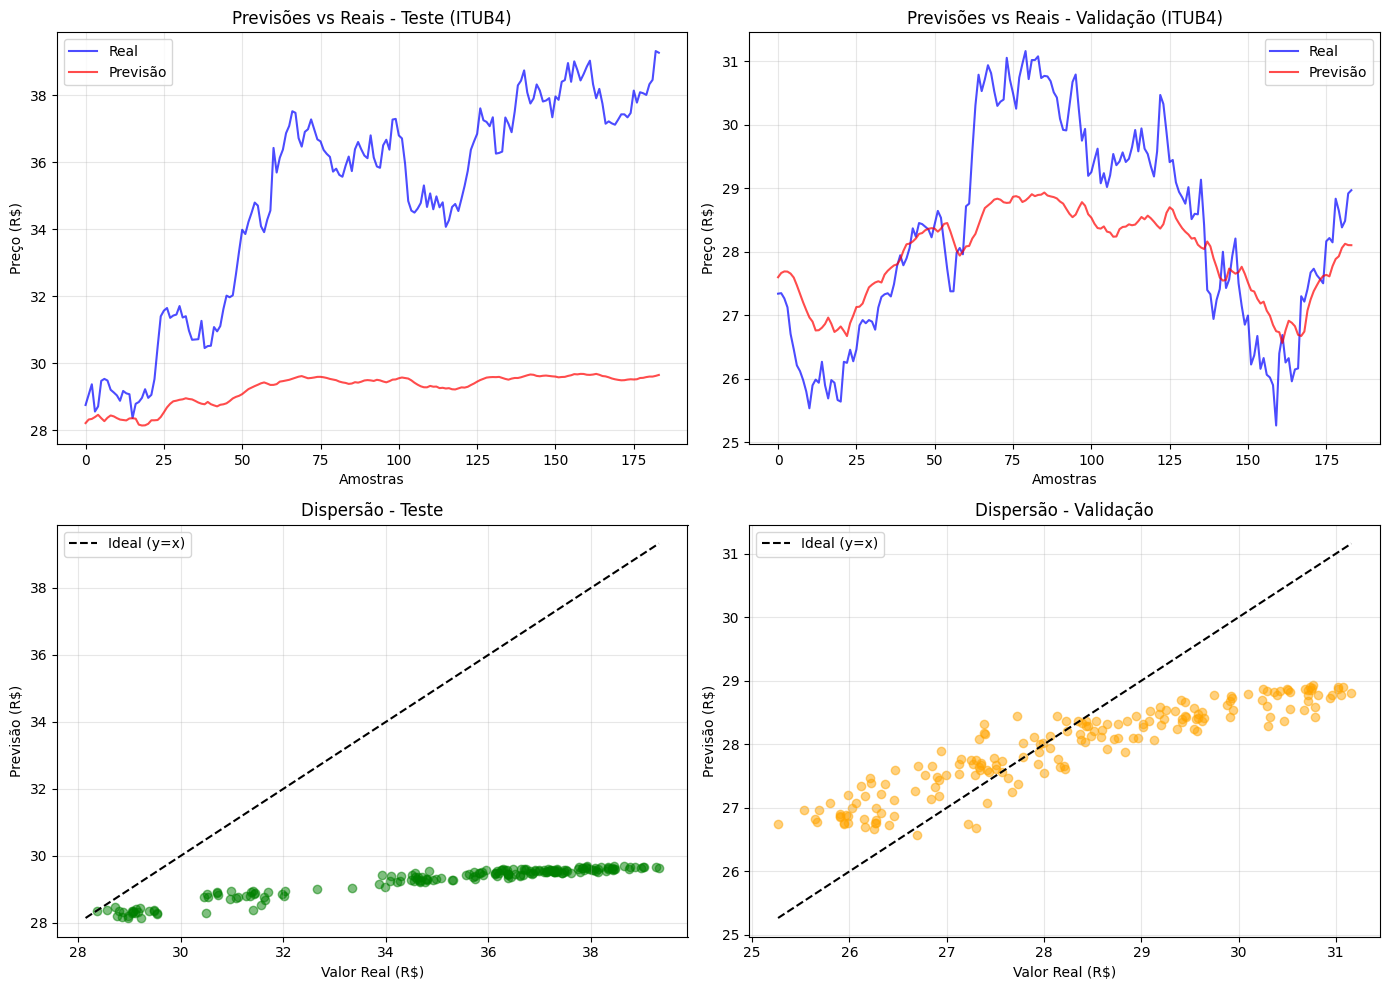

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Gráfico 1: Previsões vs Reais (Teste) - Linha do tempo
ax1 = axes[0, 0]
ax1.plot(y_test_real, label='Real', color='blue', alpha=0.7)
ax1.plot(predictions_test_real, label='Previsão', color='red', alpha=0.7)
ax1.set_title(f'Previsões vs Reais - Teste ({config.TICKER})')
ax1.set_xlabel('Amostras')
ax1.set_ylabel('Preço (R$)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Gráfico 2: Previsões vs Reais (Validação) - Linha do tempo
ax2 = axes[0, 1]
ax2.plot(y_val_real, label='Real', color='blue', alpha=0.7)
ax2.plot(predictions_val_real, label='Previsão', color='red', alpha=0.7)
ax2.set_title(f'Previsões vs Reais - Validação ({config.TICKER})')
ax2.set_xlabel('Amostras')
ax2.set_ylabel('Preço (R$)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Gráfico 3: Scatter plot (Teste)
ax3 = axes[1, 0]
ax3.scatter(y_test_real, predictions_test_real, alpha=0.5, color='green')
min_val = min(y_test_real.min(), predictions_test_real.min())
max_val = max(y_test_real.max(), predictions_test_real.max())
ax3.plot([min_val, max_val], [min_val, max_val], 'k--', label='Ideal (y=x)')
ax3.set_title('Dispersão - Teste')
ax3.set_xlabel('Valor Real (R$)')
ax3.set_ylabel('Previsão (R$)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Gráfico 4: Scatter plot (Validação)
ax4 = axes[1, 1]
ax4.scatter(y_val_real, predictions_val_real, alpha=0.5, color='orange')
min_val = min(y_val_real.min(), predictions_val_real.min())
max_val = max(y_val_real.max(), predictions_val_real.max())
ax4.plot([min_val, max_val], [min_val, max_val], 'k--', label='Ideal (y=x)')
ax4.set_title('Dispersão - Validação')
ax4.set_xlabel('Valor Real (R$)')
ax4.set_ylabel('Previsão (R$)')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analise da baixa Performance do modelo

In [ ]:
# ============================================================
# DIAGNÓSTICO: Por que R² está negativo?
# ============================================================

print("📊 ANÁLISE DO SCALER (TARGET)")
print("="*60)

# Range que o scaler aprendeu no TREINO
train_min = target_scaler.data_min_[0]
train_max = target_scaler.data_max_[0]
print(f"\n🔵 Range do TREINO (usado para normalizar):")
print(f"   Min: R$ {train_min:.2f}")
print(f"   Max: R$ {train_max:.2f}")

print(f"\n🟠 Range da VALIDAÇÃO (real):")
print(f"   Min: R$ {y_val_real.min():.2f}")
print(f"   Max: R$ {y_val_real.max():.2f}")

print(f"\n🔴 Range do TESTE (real):")
print(f"   Min: R$ {y_test_real.min():.2f}")
print(f"   Max: R$ {y_test_real.max():.2f}")

# Verificar se está fora do range
val_fora = (y_val_real.min() < train_min) or (y_val_real.max() > train_max)
test_fora = (y_test_real.min() < train_min) or (y_test_real.max() > train_max)

print(f"\n⚠️  PROBLEMA DETECTADO:")
print(f"   Validação fora do range de treino: {'SIM ❌' if val_fora else 'NÃO ✅'}")
print(f"   Teste fora do range de treino: {'SIM ❌' if test_fora else 'NÃO ✅'}")

# Verificar output do modelo
print(f"\n📈 Output do modelo (normalizado 0-1):")
print(f"   Previsões Val - Min: {predictions_val.min():.4f}, Max: {predictions_val.max():.4f}")
print(f"   Previsões Test - Min: {predictions_test.min():.4f}, Max: {predictions_test.max():.4f}")

# O que o sigmoid limita
print(f"\n🔒 Sigmoid limita output entre 0 e 1")
print(f"   Se target normalizado > 1, modelo NUNCA vai acertar!")

# Calcular target normalizado
y_test_normalized = datamodule.test_dataset.y
print(f"\n📊 Target TESTE (normalizado):")
print(f"   Min: {y_test_normalized.min():.4f}")
print(f"   Max: {y_test_normalized.max():.4f}")

if y_test_normalized.max() > 1 or y_test_normalized.min() < 0:
    print(f"\n❌ PROBLEMA: Target de teste está FORA do range 0-1!")
    print(f"   O scaler foi ajustado no treino, mas teste tem valores diferentes.")
    print(f"   Sigmoid não consegue produzir valores > 1 ou < 0.")

In [ ]:
itub4_df = pd.read_parquet("data/train/ITUB4.parquet")

In [ ]:
itub4_df.head(50)

In [ ]:
len(itub4_df)

# Predição de preços de ações

In [ ]:
# Carregar dados para predição
predict_df = pd.read_parquet(f'data/predict/{config.TICKER}.parquet')
predict_df = StocksDataModule.drop_columns(predict_df, config.DROP_COLUMNS)

print(f"📊 Dados para predição: {predict_df.shape}")

In [ ]:
def prepare_prediction_data(df, config, feature_scaler):
    """Prepara dados para predição (sem target)."""
    
    # Normalizar features
    scaled_features = feature_scaler.transform(df[config.FEATURE_COLS])
    
    # Criar sequências (só features, sem target)
    X = []
    for i in range(config.SEQUENCE_LENGTH, len(scaled_features)):
        X.append(scaled_features[i - config.SEQUENCE_LENGTH:i])
    
    X = np.array(X, dtype=np.float32)
    
    # Se quiser prever o PRÓXIMO dia, pegar a última sequência
    last_sequence = scaled_features[-config.SEQUENCE_LENGTH:]
    last_sequence = np.array([last_sequence], dtype=np.float32)
    
    return torch.tensor(last_sequence)

In [ ]:
# Preparar dados
predict_input = prepare_prediction_data(
    predict_df, 
    config, 
    datamodule.feature_scaler
)

print(f"✅ Input para predição: {predict_input.shape}")
print(f"   Shape esperado: (1, {config.SEQUENCE_LENGTH}, {len(config.FEATURE_COLS)})")

In [ ]:
# Mover modelo para o device
model = model.to(config.ACCELERATOR)
model.eval()

with torch.no_grad():
    # Forçar CPU -> device
    predict_tensor = predict_input.detach().clone().to(config.ACCELERATOR)
    prediction_normalized = model(predict_tensor)

# Converter para valor real
prediction_real = target_scaler.inverse_transform(
    prediction_normalized.cpu().numpy().reshape(-1, 1)
)

print(f"\n{'='*60}")
print(f"PREDIÇÃO - {config.TICKER}")
print(f"{'='*60}")
print(f"\n📈 Preço previsto para o próximo dia:")
print(f"   R$ {prediction_real[0][0]:.2f}")
print(f"\n{'='*60}")

# Salvando o modelo

In [ ]:
# Salvar modelo final com nome descritivo e scalers

# Criar pasta para modelos salvos
MODELS_DIR = "models"
os.makedirs(MODELS_DIR, exist_ok=True)

# Nome descritivo com métricas e data
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
model_name = f"{config.TICKER}_LSTM"

# Salvar checkpoint do modelo
model_path = f"{MODELS_DIR}/{model_name}.ckpt"
trainer.save_checkpoint(model_path)

# Salvar scalers (necessários para previsões futuras)
scalers_path = f"{MODELS_DIR}/{model_name}_scalers.pkl"
joblib.dump({
    'feature_scaler': datamodule.feature_scaler,
    'target_scaler': datamodule.target_scaler
}, scalers_path)

# Salvar métricas
metrics_path = f"{MODELS_DIR}/{model_name}_metrics.pkl"
joblib.dump({
    'validacao': metricas_val,
    'teste': metricas_test,
    'config': {
        'SEQUENCE_LENGTH': config.SEQUENCE_LENGTH,
        'BATCH_SIZE': config.BATCH_SIZE,
        'LEARNING_RATE': config.LEARNING_RATE,
        'DROPOUT_VALUE': config.DROPOUT_VALUE,
        'WEIGHT_DECAY': config.WEIGHT_DECAY,
        'GRADIENT_CLIP_VAL': config.GRADIENT_CLIP_VAL,
        'INIT_HIDDEN_SIZE': config.INIT_HIDDEN_SIZE,
        'SECOND_HIDDEN_SIZE': config.SECOND_HIDDEN_SIZE,
    }
}, metrics_path)

print(f"\n{'='*60}")
print(f"✅ MODELO SALVO COM SUCESSO!")
print(f"{'='*60}")
print(f"\n📁 Arquivos salvos em '{MODELS_DIR}/':")
print(f"   🧠 Modelo: {model_name}.ckpt")
print(f"   📊 Scalers: {model_name}_scalers.pkl")
print(f"   📈 Métricas: {model_name}_metrics.pkl")
print(f"\n🏆 Métricas do modelo salvo:")
print(f"   R²: {metricas_test['r2']*100:.2f}%")
print(f"   MAPE: {metricas_test['mape']:.2f}%")
print(f"   MAE: R$ {metricas_test['mae']:.4f}")
print(f"   Acurácia Direcional: {metricas_test['da']*100:.2f}%")